LSTM model to predict Time to Failure

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
import time
import tensorflow as tf
import h5py


In [ ]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix-1, -1]  #last column is assumed to be the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'TTF':data['TTF'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()})  
df1 = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3786:136185].ravel(), 'freqQAmpI_filt':data2['freqQAmpI_filt'][3786:136185].ravel(),
                    'freqQAmpI_filt_pc':data2['freqQAmpI_filt_pc'].ravel()})

df = pd.concat([df1, df2], axis=1)

df = df[['freqQAmpI_filt', 'freqQAmpI_filt_pc', 'V_filt', 'Vel_pc','TTF']]
print("Input data:\n", df)


Input data:
         freqQAmpI_filt  freqQAmpI_filt_pc       V_filt  Vel_pc  TTF
0         31453.223522                0.0  5489.978529     0.0  0.0
1         31438.277060                0.0  5489.981454     0.0  0.0
2         31421.341616                0.0  5489.997639     0.0  0.0
3         31409.798761                0.0  5490.007016     0.0  0.0
4         31398.815589                0.0  5490.000189     0.0  0.0
...                ...                ...          ...     ...  ...
132394    31055.686766                0.0  5459.380488     0.0  0.0
132395    31041.955345                0.0  5459.377762     0.0  0.0
132396    31035.059531                0.0  5459.388352     0.0  0.0
132397    31020.001291                0.0  5459.398820     0.0  0.0
132398    31012.016780                0.0  5459.399041     0.0  0.0

[132399 rows x 5 columns]


In [ ]:
# Preprocessing

arr = df.to_numpy()
n_steps = 60
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))


Features shape, X =  (132340, 60, 4)
Target shape, Y =  (132340,)


In [ ]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95284, 60, 4)
Validation: (10588, 60, 4)
Testing: (26468, 60, 4)


Epoch 1/15
2978/2978 [==============================] - 265s 89ms/step - loss: 2.8258 - val_loss: 0.1520
Epoch 2/15
2978/2978 [==============================] - 266s 89ms/step - loss: 0.1324 - val_loss: 0.1357
Epoch 3/15
2978/2978 [==============================] - 265s 89ms/step - loss: 0.1122 - val_loss: 0.1266
Epoch 4/15
2978/2978 [==============================] - 264s 89ms/step - loss: 0.1048 - val_loss: 0.1241
Epoch 5/15
2978/2978 [==============================] - 264s 89ms/step - loss: 0.1000 - val_loss: 0.1528
Epoch 6/15
2978/2978 [==============================] - 261s 88ms/step - loss: 0.0978 - val_loss: 0.1612
Epoch 7/15
2978/2978 [==============================] - 260s 87ms/step - loss: 0.0958 - val_loss: 0.0994
Epoch 8/15
2978/2978 [==============================] - 260s 87ms/step - loss: 0.0914 - val_loss: 0.1111
Epoch 9/15
2978/2978 [==============================] - 267s 89ms/step - loss: 109.0528 - val_loss: 0.1051
Epoch 10/15
2978/2978 [==============================

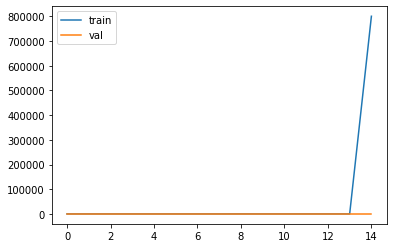

---Training time: 3980.21458530 seconds ---


In [ ]:
# Build the model

np.random.seed(0)   # To get reproducible results
#tf.random.set_seed(0)

model = Sequential()
model.add(LSTM(128, activation='relu', kernel_initializer='normal', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
#model.add(Flatten())
model.add(Dense(1, kernel_initializer='normal', activation='relu'))
model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


In [ ]:
print(model.summary())
plot_model(model, show_shapes=True)
#model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/LSTM_ttf.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               68096     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 76,417
Trainable params: 76,417
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()

test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_r2, val_r2, test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_rmse, val_rmse, test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

R2 scores: Train - 0.90468, Validation - 0.91492, Test - 0.84856
RMSE scores: Train - 0.32396, Validation - 0.33407, Test - 0.44746

---Time for Test data prediction: 6.13852334 seconds ---


Text(0.5, 1.0, 'Time to Failure prediction using LSTM model')

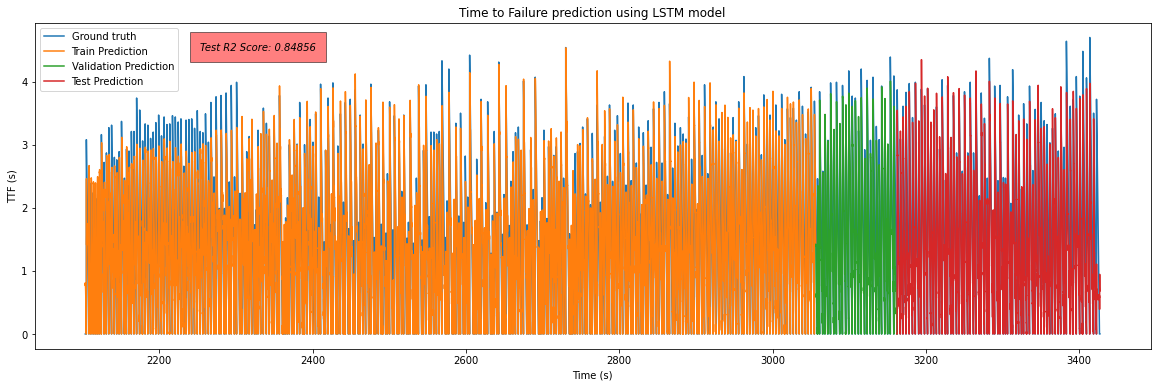

In [ ]:
# Overall plot

ttime = df1['Time'][n_steps-1:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.1, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf)
plt.plot(traintime, y_predTrain)
plt.plot(valtime, y_predVal)
plt.plot(testtime, y_predTest)
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.text(ttime.iloc[15000], 4.5, 'Test R2 Score: %0.5f' %(test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Time to Failure prediction using LSTM model')


In [ ]:
# Save predictions
'''
hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/lstm_ttf1.h5', 'w')
hf.create_dataset('y_predTrain', data=y_predTrain)
hf.create_dataset('y_predVal', data=y_predVal)
hf.create_dataset('y_predTest', data=y_predTest)
hf.close()
'''

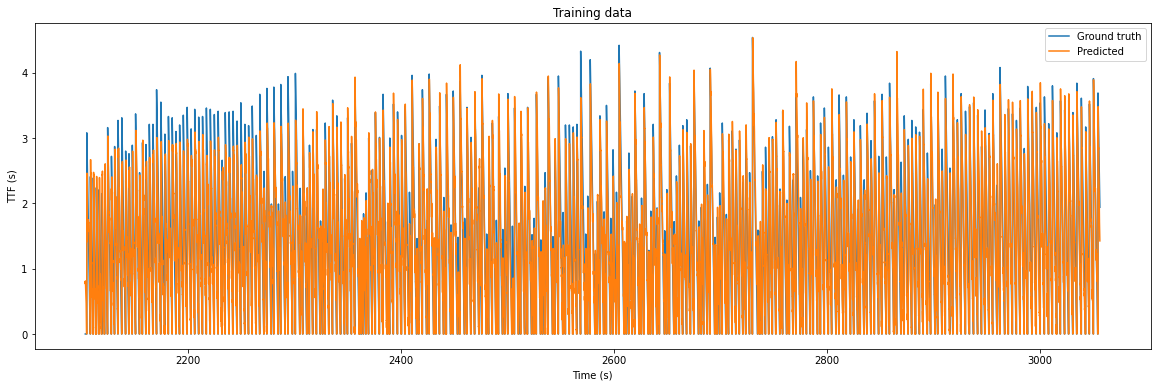

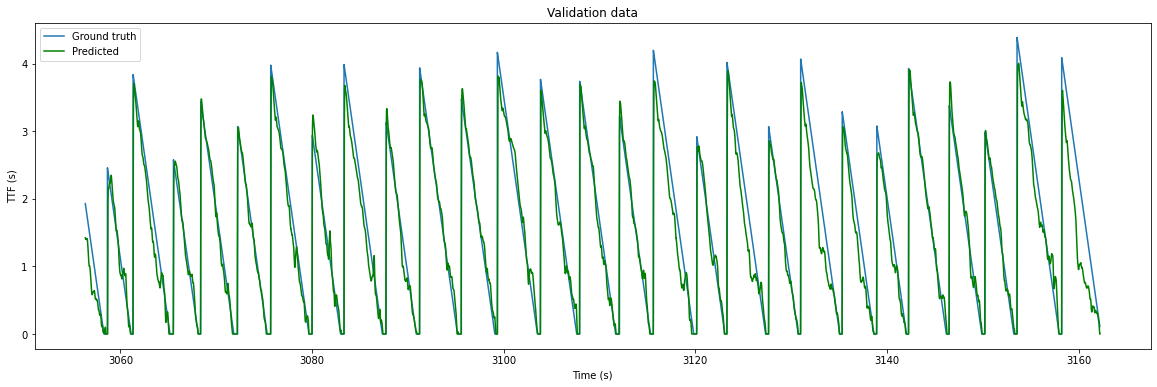

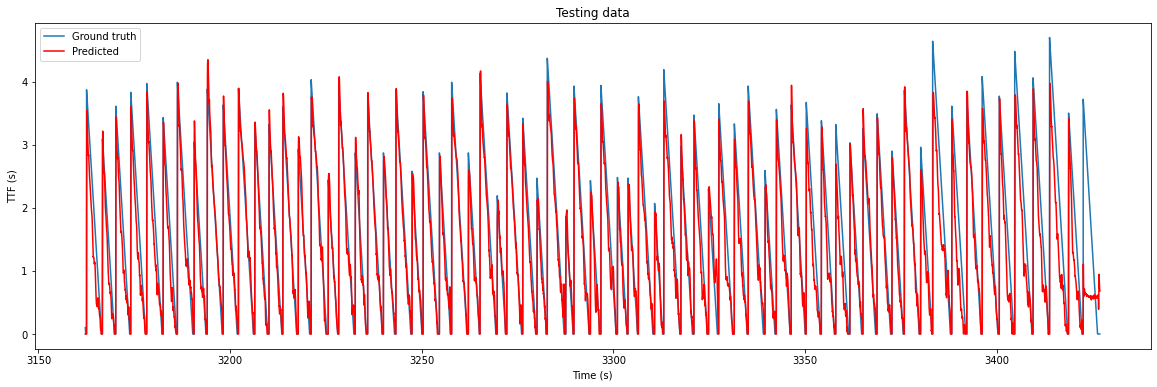

In [ ]:
# Individual plots

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('TTF (s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train, y_predTrain, 'Training data', '')
results_plot(2, valtime, Y_val, y_predVal, 'Validation data', 'g')
results_plot(3, testtime, y_test, y_predTest, 'Testing data', 'r')


Text(0.5, 1.0, 'Detailed View, Testing Data')

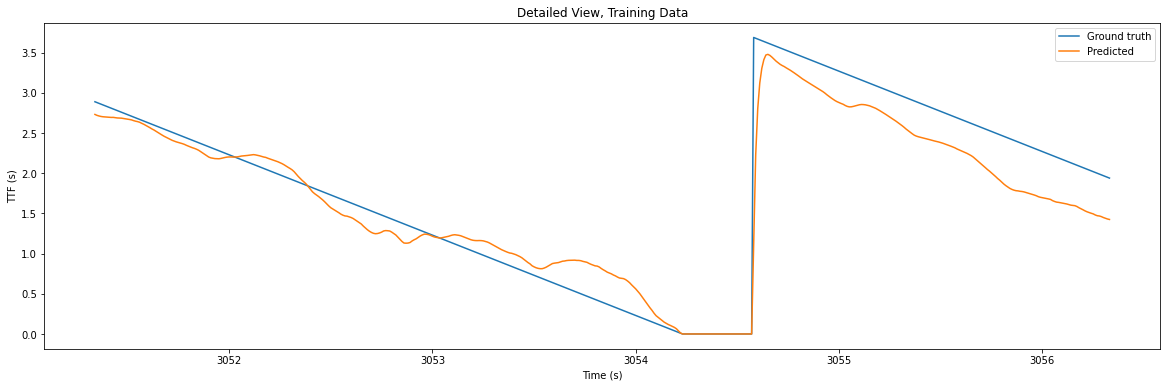

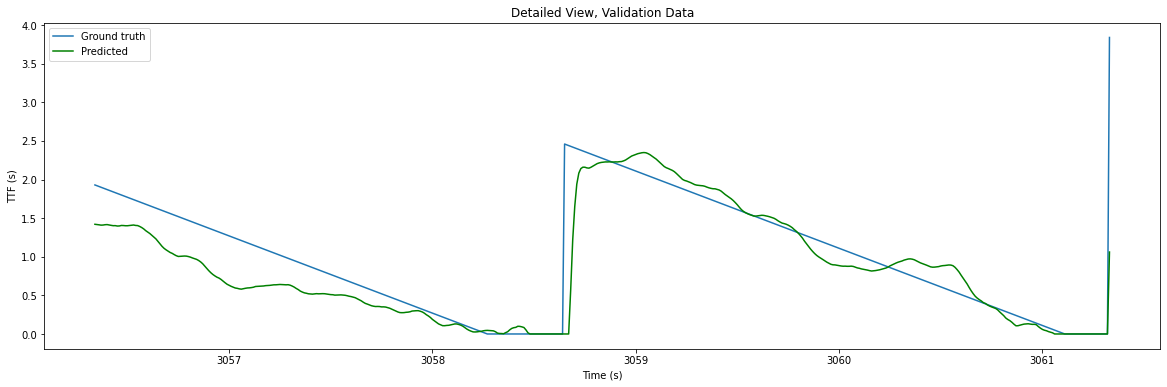

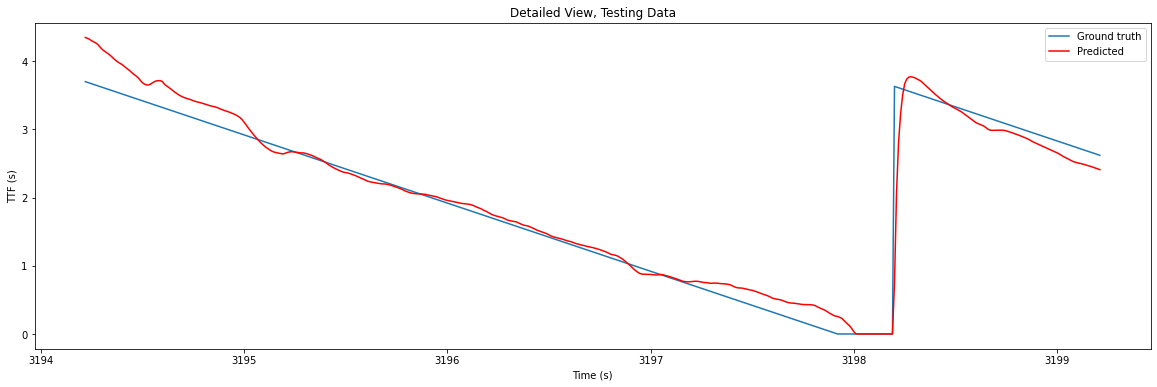

In [ ]:
# Detailed view of the plots

n=500

fig = plt.figure(4, figsize=(20,6))
plt.plot(traintime[-n:], Y_train[-n:])
plt.plot(traintime[-n:], y_predTrain[-n:])
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(valtime[:n], Y_val[:n])
plt.plot(valtime[:n], y_predVal[:n], 'g')
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

st_i = 3200
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test[st_i:st_i+n])
plt.plot(testtime[st_i:st_i+n], y_predTest[st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


Text(0.5, 1.0, 'TTF')

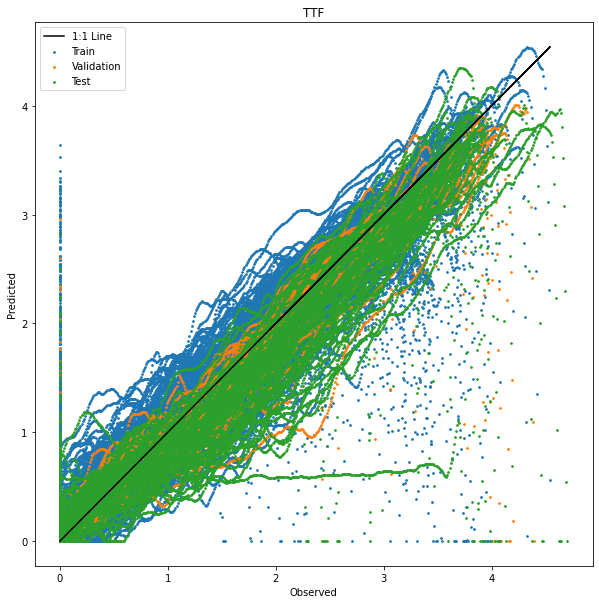

In [ ]:
# Regression analysis
fig = plt.figure(7, figsize=(10,10))
plt.plot(Y_train, Y_train, 'black')
plt.scatter(Y_train, y_predTrain, s=3)
plt.scatter(Y_val, y_predVal, s=3)
plt.scatter(y_test, y_predTest, s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('TTF')
